# Real or AI

### Results analysis

In [1]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import Image, display

# Style
sns.set(style="whitegrid")

# Utils
def display_img(filename):
    path = "../data/" + filename
    display(Image(filename=path, width=300))

In [2]:
# Read data
data = pd.read_csv('roa-responses.csv', sep=';')
label = pd.read_csv('../label.csv')
label.rename(columns={'filename': 'image_id'}, inplace=True)

# timestamp en datetime
data["timestamp"] = pd.to_datetime(data["timestamp"])

# Merge pour avoir le vrai label pour chaque image
df = data.merge(label, on="image_id", how="left")

df.head()

timestamp                                run_id  \
0 2025-11-19 10:23:44+00:00  27c015ae-426a-4514-a1ae-a2025aef9d2a   
1 2025-11-19 10:23:44+00:00  27c015ae-426a-4514-a1ae-a2025aef9d2a   
2 2025-11-19 10:23:44+00:00  27c015ae-426a-4514-a1ae-a2025aef9d2a   
3 2025-11-19 10:23:44+00:00  27c015ae-426a-4514-a1ae-a2025aef9d2a   
4 2025-11-19 10:23:44+00:00  27c015ae-426a-4514-a1ae-a2025aef9d2a   

                              cookie_id   image_id  response_time_ms  \
0  c91f3b63-aec2-4ac2-8258-62f12955aca4  9e8c8.png              5512   
1  c91f3b63-aec2-4ac2-8258-62f12955aca4  2d3f3.png              3935   
2  c91f3b63-aec2-4ac2-8258-62f12955aca4  ba61a.png              1078   
3  c91f3b63-aec2-4ac2-8258-62f12955aca4  acda1.png               878   
4  c91f3b63-aec2-4ac2-8258-62f12955aca4  bd1c0.png              2089   

   is_correct                                         user_agent  class  
0           0  Mozilla/5.0 (Android 13; Mobile; rv:145.0) Gec...      0  
1           0  Mozilla/5.0 (Android 13; Mobile; rv:145.0) Gec...      1  
2           0  Mozilla/5.0 (Android 13; Mobile; rv:145.0) Gec...      1  
3           1  Mozilla/5.0 (Android 13; Mobile; rv:145.0) Gec...      0  
4           1  Mozilla/5.0 (Android 13; Mobile; rv:145.0) Gec...      0

In [3]:
# Remove first session (it was a test I did)
df = df.iloc[20:]

# Statistics

In [4]:
# Score par session (user training)
session_scores = df.groupby(["cookie_id", "run_id"])["is_correct"].mean().reset_index()

# Trier les sessions dans l'ordre chronologique pour chaque user
session_scores = session_scores.merge(
    df.groupby("run_id")["timestamp"].min().rename("session_start"),
    on="run_id",
    how="left"
)

session_scores = session_scores.sort_values(["cookie_id", "session_start"])

# Ajouter un numéro de session pour chaque utilisateur
session_scores["session_number"] = session_scores.groupby("cookie_id").cumcount() + 1

n_sessions = len(df) / 20

In [5]:
# Main score
global_accuracy = df["is_correct"].mean()
session_std = session_scores['is_correct'].std()
print("Score moyen global :", round(global_accuracy*100, 2), "±", round(session_std*100, 2), "%")
print("Standard error : ", round(session_std*100 / math.sqrt(n_sessions), 2), "%")

Score moyen global : 53.76 ± 14.02 %
Standard error :  0.92 %


In [6]:
n_users = df["cookie_id"].nunique()
print("Unique users :", n_users)

Unique users : 165


In [7]:
print("Nombre total de sessions :", n_sessions)

Nombre total de sessions : 233.0


In [8]:
print("Nombre moyen de sessions par utilisateur :", round(n_sessions / n_users, 2))

Nombre moyen de sessions par utilisateur : 1.41


In [9]:
sessions_per_user = session_scores.groupby("cookie_id")["run_id"].nunique()
prop_one_session = (sessions_per_user == 1).mean()
print("Proportion d’utilisateurs avec une seule session :", round(prop_one_session*100, 2), "%")

Proportion d’utilisateurs avec une seule session : 75.76 %


In [10]:
# Per class (0 is real, 1 is fake)
accuracy_per_class = df.groupby("class")["is_correct"].mean().reset_index()
accuracy_per_class["accuracy_percent"] = accuracy_per_class["is_correct"] * 100
accuracy_per_class

class  is_correct  accuracy_percent
0      0    0.557568         55.756792
1      1    0.517727         51.772747

In [11]:
# First session only score
first_sessions = session_scores[session_scores["session_number"] == 1]
first_session_accuracy = first_sessions["is_correct"].mean()
print("Average first session score:", round(first_session_accuracy*100, 2), "%")

Average first session score: 53.33 %


In [12]:
# Best and worst
print("Best score :", session_scores["is_correct"].max() * 100, "%")
print("Worst score :", session_scores["is_correct"].min() * 100, "%")

Best score : 90.0 %
Worst score : 15.0 %


/var/folders/48/4n4hcp112zbdf81wrzbqmc3c0000gn/T/ipykernel_4358/2619096055.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


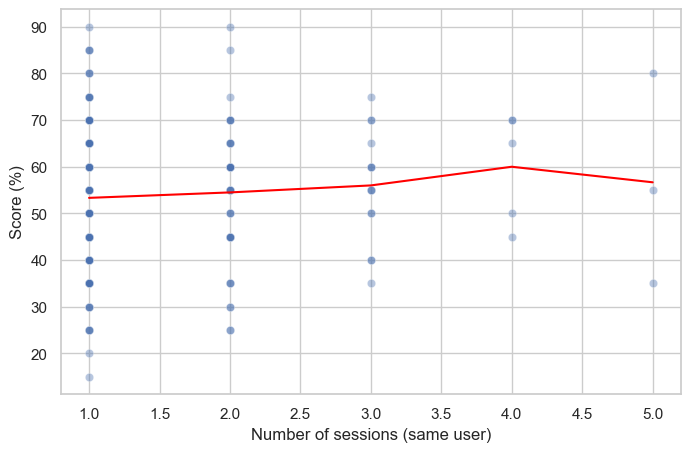

In [31]:
sss = session_scores[session_scores['session_number'] <= 5]

plt.figure(figsize=(8,5))

sns.scatterplot(
    data=sss,
    x="session_number",
    y=session_scores["is_correct"]*100,
    alpha=0.4
)

sns.lineplot(
    data=sss,
    x="session_number",
    y=session_scores["is_correct"]*100,
    ci=None,
    estimator="mean",
    color="red"
)

plt.xlabel("Number of sessions (same user)")
plt.ylabel("Score (%)")
#plt.title("Progression des utilisateurs (scatter + tendance moyenne)")
plt.show()

# Most and less deceptive images

In [14]:
# Confusion per image
confusion_per_image = df.groupby("image_id")["is_correct"].agg(["mean","count"])

In [15]:
confusion_per_image = confusion_per_image.merge(
    label[["image_id", "class"]],
    on="image_id",
    how="left"
)

In [16]:
confusion_per_image

image_id      mean  count  class
0    02573.png  0.666667     45      1
1    07646.png  0.718750     32      0
2    09343.png  0.512195     41      1
3    09b84.png  0.475000     40      0
4    0e02a.png  0.363636     33      0
..         ...       ...    ...    ...
115  fa711.png  0.326087     46      0
116  fa7d1.png  0.487805     41      0
117  fc6bc.png  0.515152     33      0
118  fde7c.png  0.511111     45      0
119  fe660.png  0.542857     35      1

[120 rows x 4 columns]

In [38]:
print("Worst image score :", round(confusion_per_image['mean'].min() * 100, 2), "%")
print("Best image score :", round(confusion_per_image['mean'].max() * 100, 2), "%")

Worst image score : 26.32 %
Best image score : 87.18 %


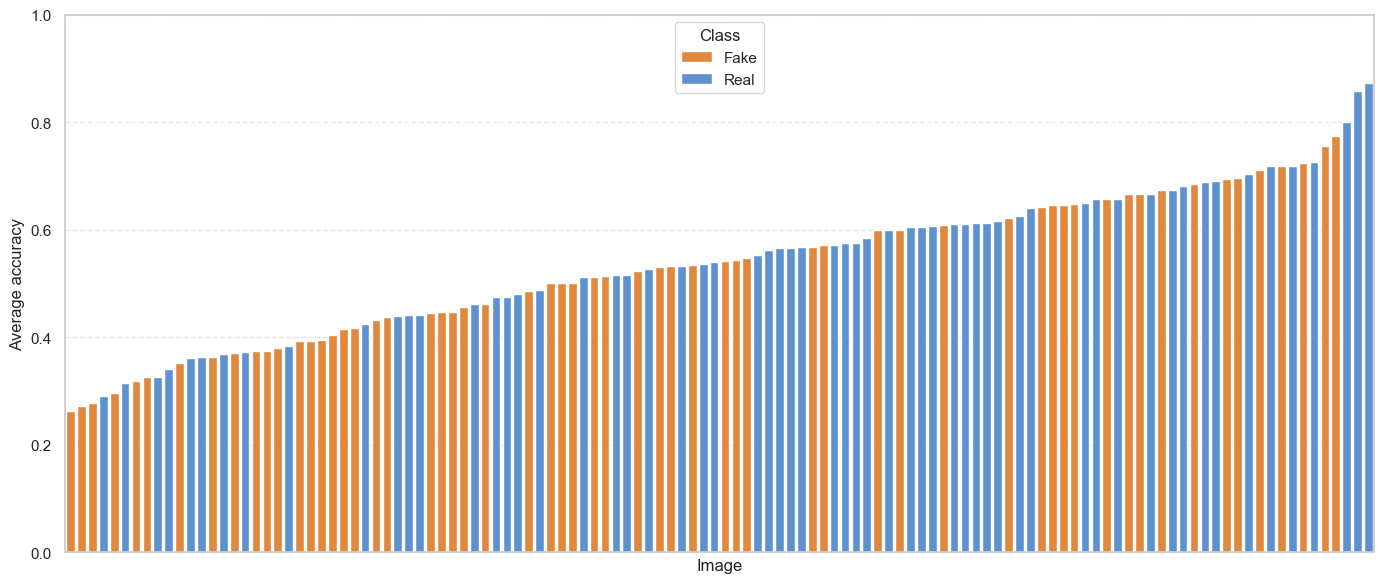

In [33]:
palette = {"Real": "#4a90e2", "Fake": "#fc8623"}
conf = confusion_per_image.copy()
conf["class"] = conf["class"].map({0: "Real", 1: "Fake"})

# Trier du plus trompeur au plus facile
conf = conf.sort_values("mean", ascending=True)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=conf,
    x="image_id",
    y="mean",
    hue="class",
    dodge=False,
    palette=palette
)

plt.ylabel("Average accuracy")
plt.xlabel("Image")
#plt.title("Accuracy per image (Real vs Fake)")

plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.xticks([])
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.legend(title="Class")
plt.tight_layout()
plt.show()

### Most and least deceptive images

Most deceptive fake image


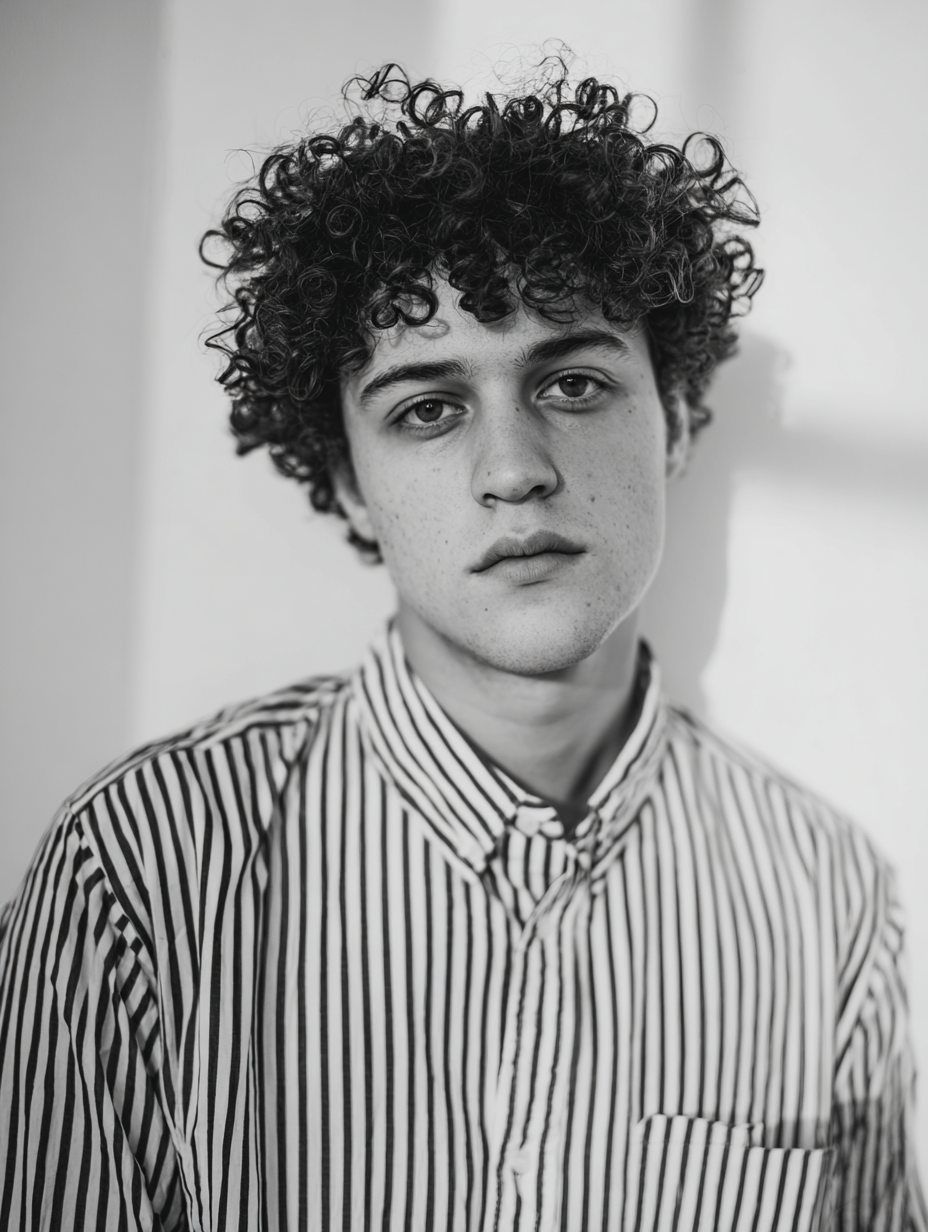

Least deceptive fake image


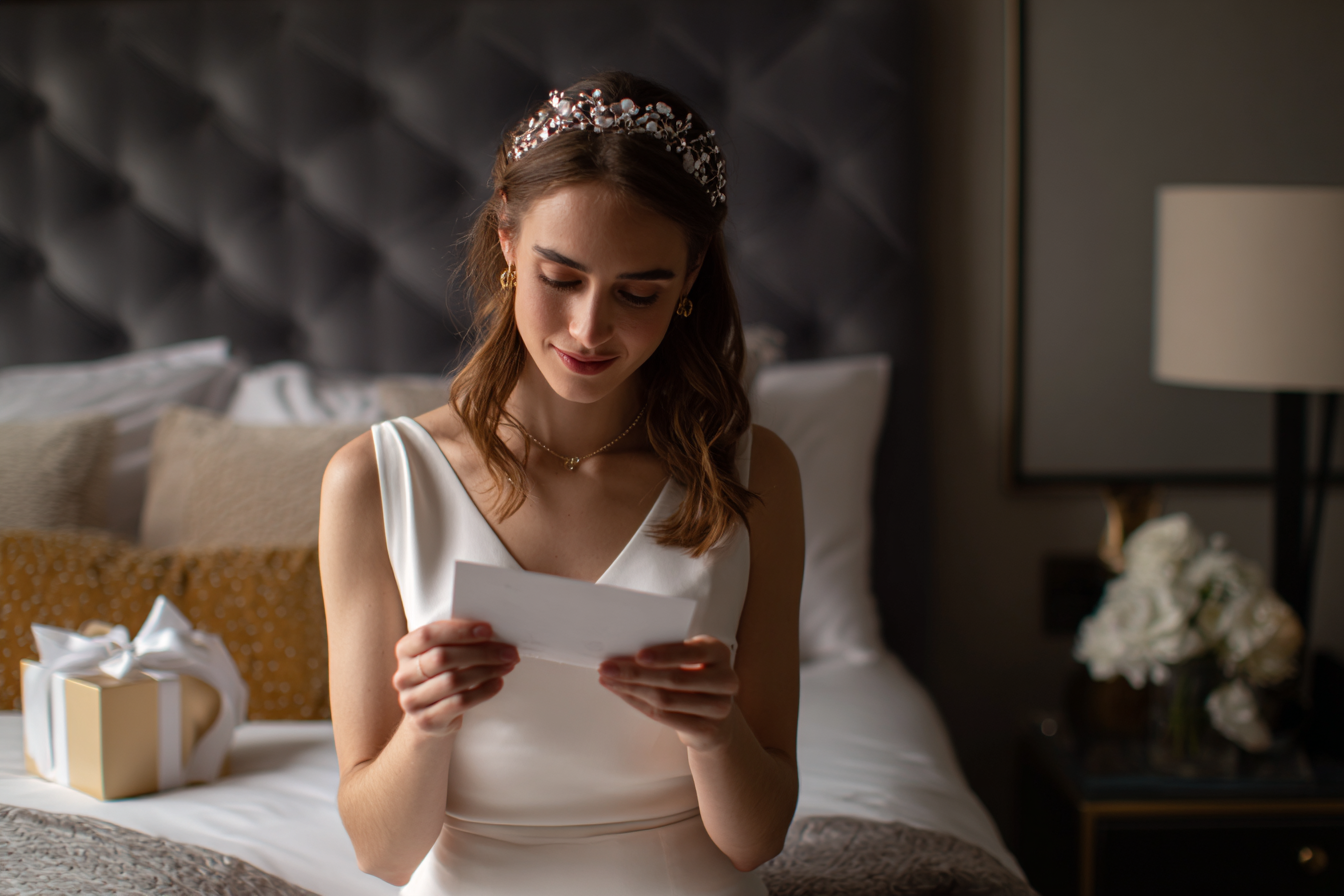

Most deceptive real image


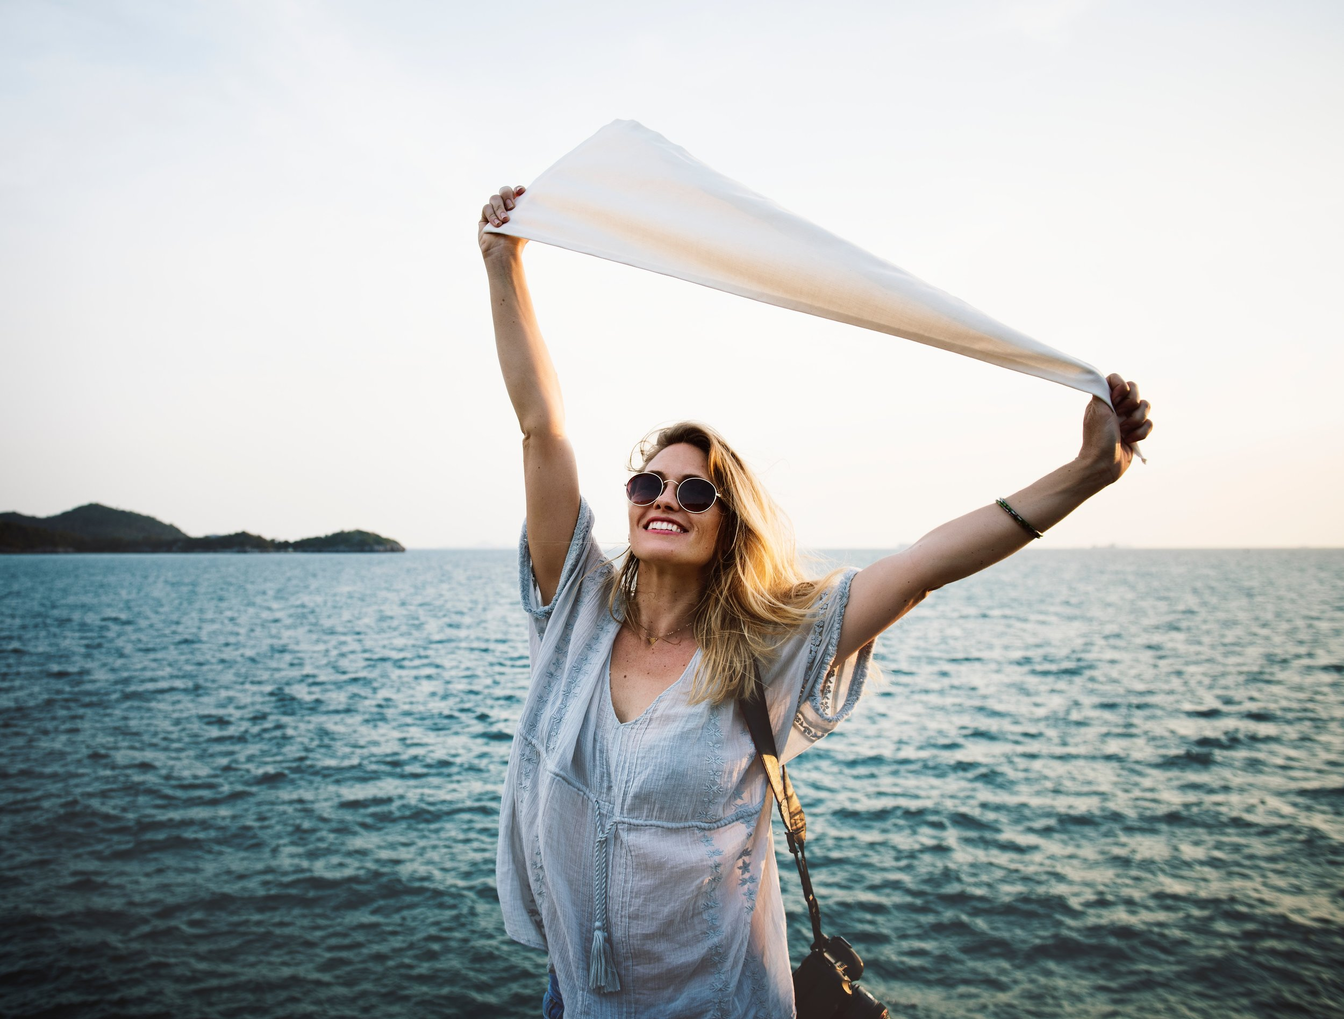

Least deceptive real image


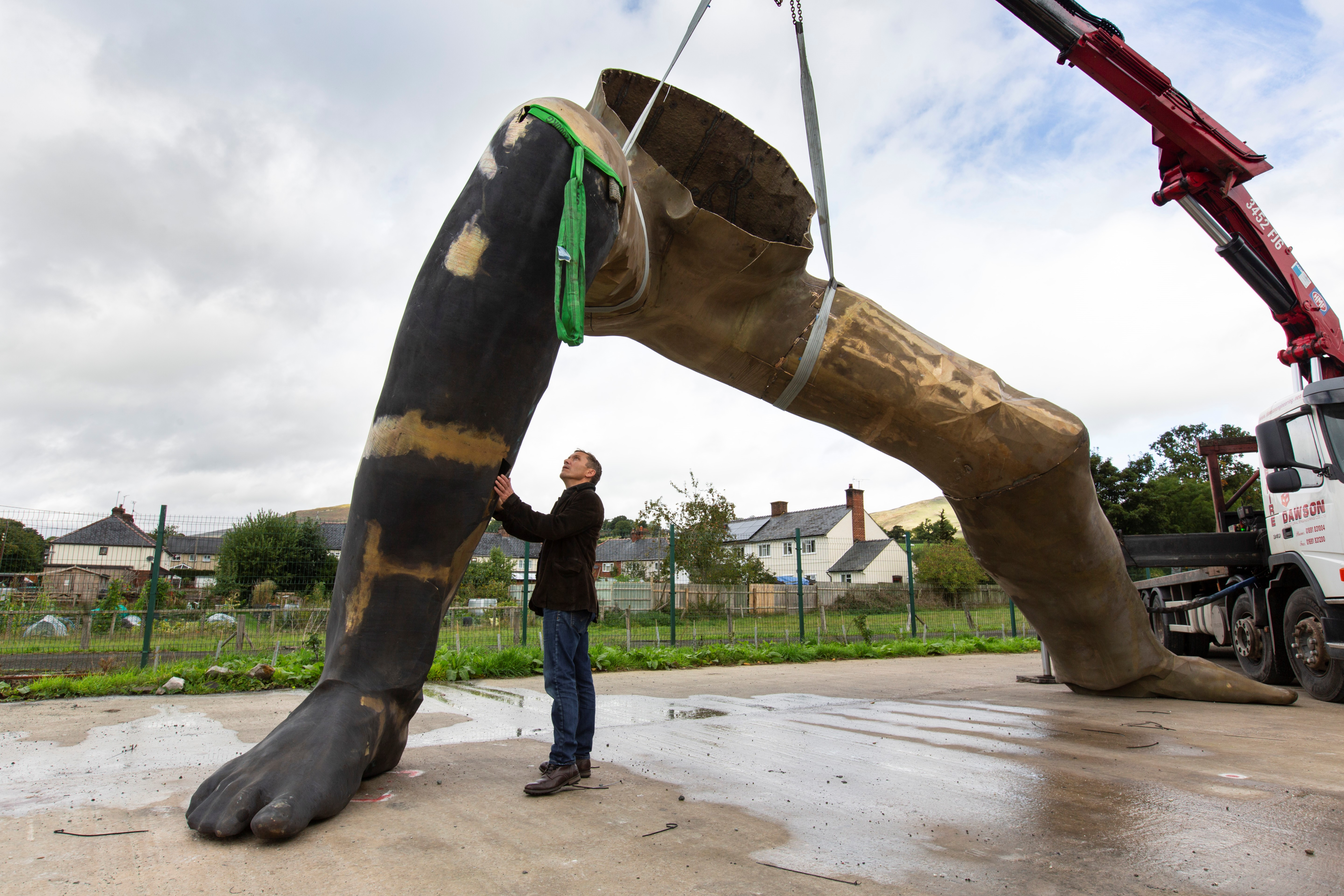

In [18]:
# Filtrer réels et fakes
real_images = confusion_per_image[confusion_per_image["class"] == 0]
fake_images = confusion_per_image[confusion_per_image["class"] == 1]

print("Most deceptive fake image")
display_img(fake_images.loc[fake_images["mean"].idxmin()]['image_id'])

print("Least deceptive fake image")
display_img(fake_images.loc[fake_images["mean"].idxmax()]['image_id'])

print("Most deceptive real image")
display_img(real_images.loc[real_images["mean"].idxmin()]['image_id'])

print("Least deceptive real image")
display_img(real_images.loc[real_images["mean"].idxmax()]['image_id'])


# Users

In [19]:
score_counts = (
    session_scores["is_correct"]
    .value_counts()
    .sort_index()
    .reset_index()
)
score_counts.columns = ['Score', 'Count']

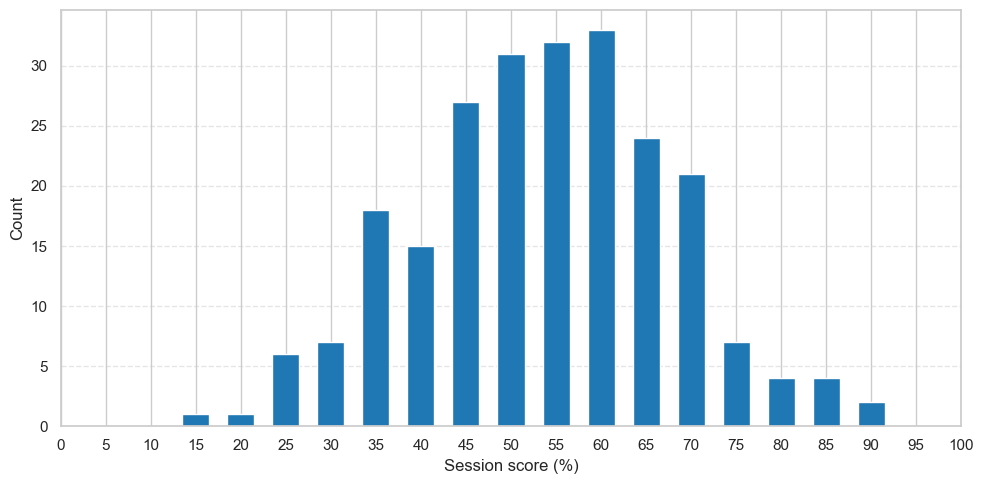

In [20]:
plt.figure(figsize=(10,5))

score_counts["Score_percent"] = (score_counts["Score"] * 100).round()
score_counts = score_counts.sort_values("Score_percent")

plt.bar(
    score_counts["Score_percent"],
    score_counts["Count"],
    width=3,
    color="#1f77b4"
)

plt.xlabel("Session score (%)")
plt.ylabel("Count")
#plt.title("Distribution of session scores")
plt.xticks(range(0, 101, 5))
plt.xlim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
# Distribution des scores ?

In [22]:
# best
df.groupby("cookie_id")["is_correct"].mean().sort_values(ascending=False).head()

cookie_id
f7ce64d7-68ce-413d-ab10-8eb7830aee79    0.85
faa47210-88c6-46a9-91d1-3f7064331993    0.85
19b2cad8-7292-43ab-9427-b25e384b9d39    0.80
0d7f20c6-de03-4b55-b84e-7e3fdcd1cb38    0.80
b4a77b9e-7981-45a0-9906-57519dc47cc2    0.80
Name: is_correct, dtype: float64

In [23]:
# quickest
df.groupby("run_id")["response_time_ms"].mean().sort_values().head()

run_id
89e6efca-283c-413e-96ed-8bf84fba455d    208.90
9f0233bb-7276-495f-8130-405a29c8a029    210.55
deee52ee-23e3-49ce-861a-4361e3466339    474.30
4c063524-cccb-4479-af25-832960224005    481.35
9df911c5-c52b-4b49-b53b-80f4f8068bea    490.10
Name: response_time_ms, dtype: float64

# Response time

In [24]:
df["response_time_s"] = df["response_time_ms"] / 1000

In [25]:
print("Average response time:", df["response_time_s"].mean(), "seconds")

Average response time: 7.335342489270386 seconds


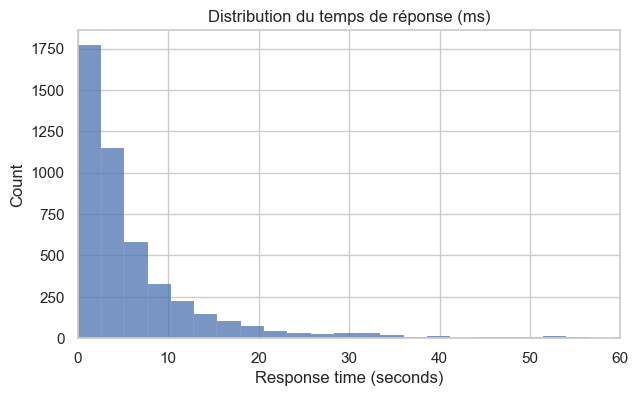

In [26]:
# Histogram
plt.figure(figsize=(7,4))
sns.histplot(df["response_time_s"], bins=700)
plt.xlim((0, 60))
plt.xlabel('Response time (seconds)')
plt.title("Distribution du temps de réponse (ms)")
plt.show()

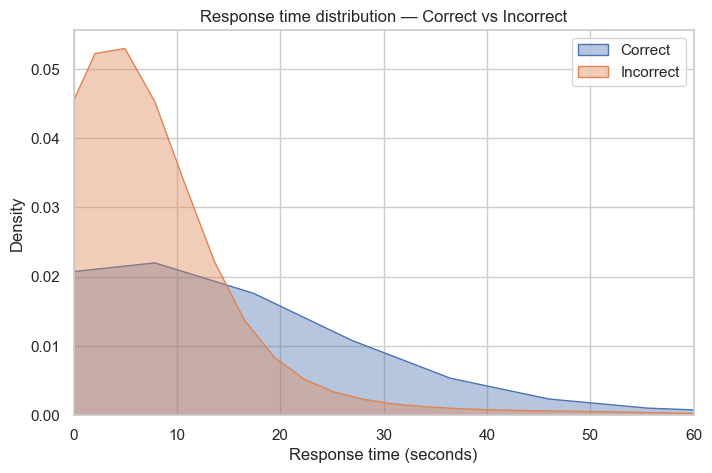

In [27]:
# Time vs accuracy
plt.figure(figsize=(8,5))

sns.kdeplot(
    df[df["is_correct"]==1]["response_time_s"],
    fill=True,
    alpha=0.4,
    label="Correct",
    bw_adjust=2
)

sns.kdeplot(
    df[df["is_correct"]==0]["response_time_s"],
    fill=True,
    alpha=0.4,
    label="Incorrect",
    bw_adjust=2
)

plt.xlabel("Response time (seconds)")
plt.ylabel("Density")
plt.xlim((0, 60))
plt.title("Response time distribution — Correct vs Incorrect")
plt.legend()
plt.show()

In [28]:
session_stats = df.groupby("run_id").agg(
    total_time = ("response_time_s", "sum"),
    accuracy = ("is_correct", "mean"),
    n_answers = ("is_correct", "size")
).reset_index()

# garder uniquement les sessions complètes
session_stats = session_stats[session_stats["n_answers"] == 20]

# score en %
session_stats["score_percent"] = session_stats["accuracy"] * 100

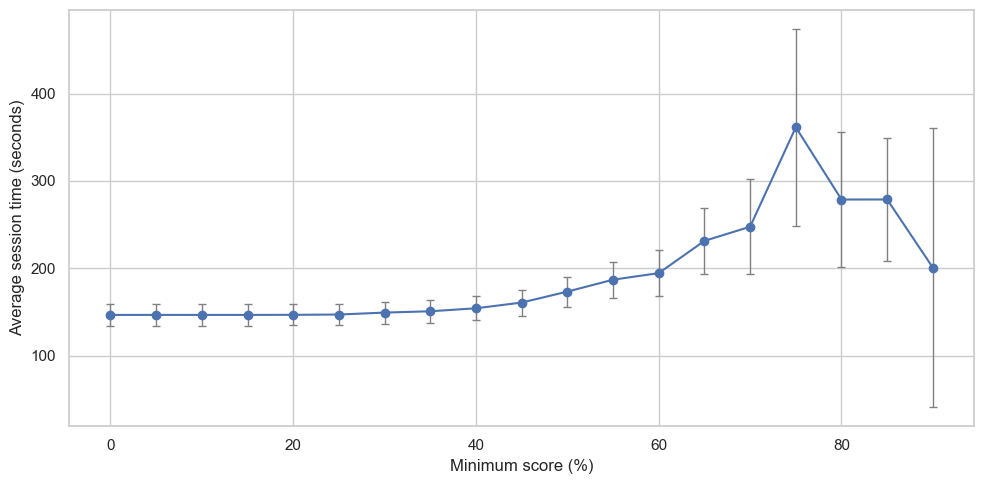

In [29]:
# Version barres d'erreur

thresholds = np.arange(0, 101, 5)
rows = []

for t in thresholds:
    subset = session_stats[session_stats["score_percent"] >= t]
    if len(subset) == 0:
        continue

    rows.append({
        "threshold": t,
        "mean_time": subset["total_time"].mean(),
        "std_time": subset["total_time"].std(),
        "n": len(subset)
    })

cum = pd.DataFrame(rows)
cum["stderr"] = cum["std_time"] / cum["n"]**0.5

plt.figure(figsize=(10,5))

plt.errorbar(
    cum["threshold"],
    cum["mean_time"],
    yerr=cum["stderr"],
    marker="o",
    capsize=3,
    elinewidth=1,
    ecolor="gray"
)

plt.xlabel("Minimum score (%)")
plt.ylabel("Average session time (seconds)")
#plt.title("Average time for sessions with score ≥ x")
plt.grid(True)
plt.tight_layout()
plt.show()